In [1]:
import json
from collections import defaultdict, namedtuple, OrderedDict
import numpy as np
import os, shutil
import subprocess

In [2]:
import textworld

In [3]:
import networkx as nx
from textworld.generator import compile_game, make_map
from textworld.generator.game import GameOptions
from textworld.generator.graph_networks import shortest_path, plot_graph

In [4]:
from textworld.render.graph import build_graph_from_facts, show_graph
import matplotlib.pyplot as plt

In [5]:
import TextWorldUtils

In [6]:
TW_TRAINING_DIR = '/home/guntis/work/github/0_magd3/CodaLab/train'
Z8_MAP_DIR = TW_TRAINING_DIR+"/../z8_maps"
XTRACT_DIR = TW_TRAINING_DIR+"/../extracted_data"

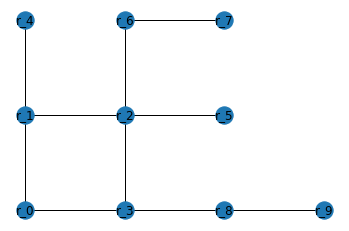

In [7]:
g10 = make_map(10, size=(4,3))
plot_graph(g10)

In [8]:
for n, d in g10.nodes.items():
    print(n, d)
print(g10.edges.data())

(0, 0) {'name': 'r_0'}
(0, 1) {'name': 'r_1'}
(1, 1) {'name': 'r_2'}
(1, 0) {'name': 'r_3'}
(0, 2) {'name': 'r_4'}
(2, 1) {'name': 'r_5'}
(1, 2) {'name': 'r_6'}
(2, 2) {'name': 'r_7'}
(2, 0) {'name': 'r_8'}
(3, 0) {'name': 'r_9'}
[((0, 0), (0, 1), OrderedDict([('has_door', False), ('door_state', None), ('door_name', None)])), ((0, 0), (1, 0), OrderedDict([('has_door', False), ('door_state', None), ('door_name', None)])), ((0, 1), (1, 1), OrderedDict([('has_door', True), ('door_state', 'closed'), ('door_name', 'd_2'), ('weight', 0.1)])), ((0, 1), (0, 2), OrderedDict([('has_door', False), ('door_state', None), ('door_name', None)])), ((1, 1), (2, 1), OrderedDict([('has_door', False), ('door_state', None), ('door_name', None)])), ((1, 1), (1, 2), OrderedDict([('has_door', True), ('door_state', 'open'), ('door_name', 'd_0'), ('weight', 0.1)])), ((1, 1), (1, 0), OrderedDict([('has_door', True), ('door_state', 'closed'), ('door_name', 'd_1'), ('weight', 0.1)])), ((1, 0), (2, 0), OrderedDict(

[(0, 0), (0, 1), (1, 1), (1, 0), (0, 2), (2, 1), (1, 2), (2, 2), (2, 0), (3, 0)] [(0.5, 1.0), (1.0, 0.5)] [(1.0, 1.5), (1.5, 0.0)]
('r_0', 'east') -> ('r_3', 'east') -> ('r_8', 'east') -> ('r_9', '.')


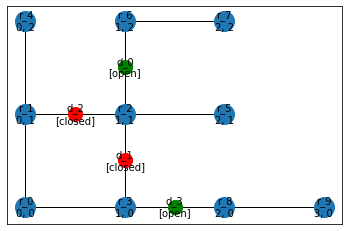

In [9]:
def name_for_node(G, n):
    return G.nodes.data()[n]['name']

def print_shortest_path(G, n0, n2):
    path = nx.algorithms.shortest_path(G, n0, n2)
    # print("n0:",(name_for_node(G,n0),n0), "n2:", name_for_node(G, n2), n2)
    names = map(lambda n: name_for_node(G, n), path)
    # print(list(names))
    path_w_names = zip(names, shortest_path(G, n0, n2)+['.'])
    print(" -> ".join(list(map(str,path_w_names))))

def get_label(n, data):
    door_state = data.get('door_state', '')
    if door_state:
        xtra = f"\n[{door_state}]"
    else:
        xtra = f"\n{n[0]}, {n[1]}"  # coords
        
    return f"{data['name']}{xtra}"

def is_door(data):
    return 'door_state' in data
#     return data['name'].startswith('d_')

def is_unknown(data):
    return data['name'].startswith('Unkn')

def is_current(data, current_pos):
    if current_pos is None:
        return False
    return data['name'] == current_pos


def door_is_open(data):
    door_state = data.get('door_state', '')
    return door_state not in ['closed', 'locked']

def draw_g(g, current_pos=None):
    pos = dict(zip(g.nodes, g.nodes))
    
    labels = {n: get_label(n, data) for n, data in g.nodes.items()}
    node_list = []
    closed_door_list = []
    open_door_list = []
    unknown_list = []
    current_list = []
    for n, data in g.nodes.items():
        if is_door(data):
            if not door_is_open(data):
                closed_door_list.append(n)
            else:
                open_door_list.append(n)
        elif is_unknown(data):
            unknown_list.append(n)
        elif is_current(data, current_pos):
            current_list.append(n)
        else:
            node_list.append(n)
            
    print(node_list, closed_door_list, open_door_list)
    
    if current_list:
        nx.draw_networkx_nodes(g, pos=pos, nodelist=current_list, node_size=600, node_color='c')

    nx.draw_networkx_nodes(g, pos=pos, nodelist=unknown_list, node_size=400, node_color='darkgrey')
    nx.draw_networkx_nodes(g, pos=pos, nodelist=node_list, node_size=400) #nx.draw(g, pos=pos labels=labels, with_labels=True)
    nx.draw_networkx_nodes(g, pos=pos, nodelist=closed_door_list, node_color='r', node_size=200) #nx.draw(g, pos=pos labels=labels, with_labels=True)
    nx.draw_networkx_nodes(g, pos=pos, nodelist=open_door_list, node_color='g', node_size=200) #nx.draw(g, pos=pos labels=labels, with_labels=True)
    nx.draw_networkx_edges(g, pos=pos)
    nx.draw_networkx_labels(g,pos,labels, font_size=10)

def graph_w_doors(G):
    Gd = G.copy()
    for ed in G.edges.data():
        if ed[2]['has_door']:
            x = (ed[0][0] + ed[1][0])/2
            y = (ed[0][1] + ed[1][1])/2
            Gd.add_node((x,y), name=ed[2]['door_name'], door_state=ed[2]['door_state'])
        #print(ed[0],ed[1], ed[2])
    return Gd

def get_doorinfo(doorentity):  # doorentity is a twutils.symbolic.entity.Door
    if doorentity is None:
        return '', True
    if doorentity.state.openable and not doorentity.state.is_open:
        return doorentity.name, False
    return doorentity.name, True


draw_g(graph_w_doors(g10))

nodes = list(g10.nodes)
print_shortest_path(g10, nodes[0], nodes[-1])


In [10]:
from TextWorldUtils import count_iter_items
# import itertools
# from collections import deque

# def count_iter_items(iterable):
#     """
#     Consume an iterable not reading it into memory; return the number of items.
#     """
#     counter = itertools.count()
#     deque(zip(iterable, counter), maxlen=0)  # (consume at C speed)
#     return next(counter)

In [11]:
env_json = TextWorldUtils.load_json('./tw_games/tw-cooking-recipe3+take3+cut+go6-Z7L8CvEPsO53iKDg.json')

In [12]:
# print(env_json.keys())
# for k,val in env_json['grammar'].items():
#     print(k,':', val)
##
## dict_keys(['world', 'grammar', 'quests', 'infos', 'KB', 'metadata', 'objective', 'extras'])
## theme : house
## names_to_exclude : []
## include_adj : False
## blend_descriptions : False
## ambiguous_instructions : False
## only_last_action : False
## blend_instructions : False
## allowed_variables_numbering : False
## unique_expansion : False
    
training_files = os.listdir(TW_TRAINING_DIR)  #[0:30]
# directory contains 3 files per game: *.json, *.ulx, *.z8 
print("Total training files = ", count_iter_items(training_files))
suffixes = ['.json', '.z8', '.ulx']
suffix = '.json'
game_json_files = list(filter(lambda fname: fname.endswith(suffix), training_files))
print("number of {} files in {} = {}".format(suffix, TW_TRAINING_DIR, len(game_json_files)))
base_names = [s.split('.')[0] for s in game_json_files]

print("Number of base_names:", len(base_names))

Total training files =  13320
number of .json files in /home/guntis/work/github/0_magd3/CodaLab/train = 4440
Number of base_names: 4440


In [13]:
len(base_names)

4440

In [14]:
from TextWorldUtils import print_ids_and_names

# # game1.kb
# # print(game1.infos.keys()) # keys are object ids
# def print_ids_and_names(game):
#     entities_infos = filter(_filter_unnamed_and_room_entities, game.infos.values())
#     room_infos = filter(_filter_rooms, game.infos.values())
#     print("ROOMS:")
#     for info in room_infos:
#         print("{}: '{}'".format(info.id, info.name ))
#     print("--------------")
#     for info in entities_infos: #game.infos.values()
#         print("{}: '{}' [{}]".format(info.id, info.name, format_adj(info.adj))) #, info.type ))

game1 = textworld.generator.Game.load('./tw_games/tw-cooking-recipe3+take3+cut+go6-Z7L8CvEPsO53iKDg.json')
print_ids_and_names(game1)
print()
print("VERBS:", game1.verbs)
print()
print("RECIPE:", '\n'.join((game1.infos['o_0'].desc.splitlines())[3:]))

ROOMS:
r_0: 'kitchen'
r_2: 'livingroom'
r_1: 'pantry'
r_3: 'bedroom'
r_5: 'bathroom'
r_4: 'corridor'
--------------
d_0: 'plain door' [None]
c_0: 'fridge' ['conventional']
oven_0: 'oven' ['conventional']
s_0: 'table' ['massive']
s_1: 'counter' ['vast']
s_2: 'shelf' ['wooden']
s_3: 'sofa' ['comfy']
s_4: 'bed' ['large']
s_5: 'toilet' ['white']
stove_0: 'stove' ['conventional']
f_0: 'purple potato' ['']
f_1: 'black pepper' ['']
f_2: 'parsley' ['']
f_3: 'orange bell pepper' ['']
f_4: 'red potato' ['']
meal_0: 'meal' [None]
o_0: 'cookbook' ['interesting']
o_1: 'knife' ['sharp']

VERBS: ['chop', 'close', 'cook', 'dice', 'drink', 'drop', 'eat', 'examine', 'go', 'insert', 'inventory', 'lock', 'look', 'open', 'prepare', 'put', 'slice', 'take', 'unlock']

RECIPE: ---------
Gather all following ingredients and follow the directions to prepare this tasty meal.

Ingredients:
  black pepper
  parsley
  purple potato

Directions:
  dice the parsley
  slice the purple potato
  roast the purple potato


In [15]:
game_name = 'tw-cooking-recipe3+take3+cook+cut+open+drop+go6-g7QjTZZPUXqRFk9N'
game_name = 'tw-cooking-recipe1+take1+cut+drop-YGy3iyJOCq2DUQo8'

obj_infos, game, env = TextWorldUtils.start_game_with_z8map(game_name,
                                training_dir=TW_TRAINING_DIR, z8map_dir=Z8_MAP_DIR)
# room_data = TextWorldUtils.extract_room_states(obj_infos, game, env)
# for r_id in room_data:
#     r_name, desc, state = room_data[r_id]
#     print('======', r_name, '======')
#     print(desc)
#     print("-------- ------ -------")
#     print(state)


In [16]:
env.reset()
gsx,score,done = env.step("examine cookbook")
print(gsx.keys())
print()
print(gsx.objective)
print(gsx.entities)

dict_keys(['last_command', 'raw', 'done', 'feedback', 'won', 'lost', 'score', 'location', 'game', 'command_templates', 'verbs', 'entities', 'objective', 'max_score', 'extra.seeds', 'extra.goal', 'extra.ingredients', 'extra.skills', 'extra.entities', 'extra.nb_distractors', 'extra.walkthrough', 'extra.max_score', 'extra.uuid', 'moves'])

You are hungry! Let's cook a delicious meal. Check the cookbook in the kitchen for the recipe. Once done, enjoy your meal!
['fridge', 'oven', 'table', 'counter', 'stove', 'red hot pepper', 'red potato', 'yellow bell pepper', 'meal', 'cookbook', 'knife', 'north', 'south', 'east', 'west']


In [17]:
request_infos = textworld.EnvInfos(
    description=True,
    feedback=True,
    admissible_commands=True,
    facts=True,
    entities=True,
    inventory=True)

# gamefile = './games/foo.z8'
# gamefile = './games/foo.ulx'
# gamefile = './tw_games/tw-cooking-recipe3+take3+cut+go6-Z7L8CvEPsO53iKDg.z8'
gamefile = TW_TRAINING_DIR+'/tw-cooking-recipe1+cook+open+go6-pRRxsa5eSpOvSVj3.z8'
gamefile = TW_TRAINING_DIR+'/tw-cooking-recipe1+cook+cut+drop+go6-ZgnGIg3Di2rKimM5.ulx'
gamefile = TW_TRAINING_DIR+'/tw-cooking-recipe1+cook+cut+open+drop+go6-xEKyIJpqua0Gsm0q.ulx'
# gamefile = TW_TRAINING_DIR+'/'+game_name+'.ulx'
# gamefile = '/home/guntis/work/0_magd3/qait_private/test_set/existence/random_map/'+\
#                  'game_0b492cf2-c513-11e9-999e-5d5562562a381_config_5_23_120000079_False_120000079.ulx'

# env = textworld.start('./tw_games/tw-cooking-'+'recipe3-yx19UYoYhLppIrp6.z8')
# env = textworld.start(TW_TRAINING_DIR+'/tw-cooking-recipe2+cut+go12-L0KgSVEBIglZT0nB.z8')
# env = textworld.start('./tw_games/tw-cooking-recipe3+take3+cut+go6-Z7L8CvEPsO53iKDg.ulx')
# env = textworld.start('./tw_games/tw-cooking-'+'recipe3-yx19UYoYhLppIrp6.ulx') #.z8')
env = textworld.start(gamefile, infos=request_infos)
# if gamefile.endswith('.ulx'):
#     env.enable_extra_info('description')   # enable_extra_info() no longer works in TW.1.3.1
#     env.enable_extra_info('inventory')
#env.activate_state_tracking()               # activate_state_tracking() no longer works in TW.1.3.1
game_state = env.reset()
# print(game_state.keys())

# print("Raw:", game_state.raw)
# print("--------------------------- Feedback: ---------------------------\n", game_state.feedback)
print("--------------------------- Description: ---------------------------\n",game_state.description)
print("--------------------------- Inventory: ---------------------------\n", game_state.inventory)

# textworld.render.visualize(game_state)      # 


--------------------------- Description: ---------------------------
 -= Livingroom =-
Well how about that, you are in a place we're calling a livingroom. Let's see what's in here.

As if things weren't amazing enough already, you can even see a sofa. The sofa is comfy. But there isn't a thing on it.

You don't like doors? Why not try going east, that entranceway is not blocked by one. You don't like doors? Why not try going north, that entranceway is not blocked by one.
--------------------------- Inventory: ---------------------------
 You are carrying:
  some water


In [18]:
print(game_state.keys())

dict_keys(['feedback', 'raw', 'game', 'command_templates', 'verbs', 'entities', 'objective', 'max_score', 'extra.seeds', 'extra.goal', 'extra.ingredients', 'extra.skills', 'extra.entities', 'extra.nb_distractors', 'extra.walkthrough', 'extra.max_score', 'extra.uuid', 'description', 'inventory', 'score', 'moves', 'won', 'lost', '_game_progression', '_facts', '_winning_policy', 'facts', '_last_action', '_valid_actions', 'admissible_commands'])


In [19]:
# game_state['_facts'] is included if EnvInfos.admissible_commands=True (even if not .facts=True)
print(game_state['_facts'][0])
print(game_state['_facts'][-1])

at(P, r_2: r)
west_of(r_0: r, r_3: r)


In [20]:
# game_state['facts'] included iff EnvInfos.facts=True
print(game_state['facts'][0])
print(game_state['facts'][-1])

at(P, livingroom: r)
west_of(kitchen: r, corridor: r)


In [21]:
# game_state['_valid_actions'] is included if EnvInfos.facts=True (even if not EnvInfos.admissible_commands=True)
print(game_state['_valid_actions'][0])
print(game_state['_valid_actions'][1])
print(game_state['_valid_actions'][-1])


drink :: in(f_0: f, I) & drinkable(f_0: f) & used(slot_0: slot) -> consumed(f_0: f) & free(slot_0: slot)
drop :: $at(P, r_2: r) & in(f_0: f, I) & used(slot_0: slot) -> at(f_0: f, r_2: r) & free(slot_0: slot)
put :: $at(P, r_2: r) & $at(s_3: s, r_2: r) & in(f_0: f, I) & used(slot_0: slot) -> on(f_0: f, s_3: s) & free(slot_0: slot)


In [22]:
# game_state['admissible_commands'] included iff EnvInfos.admissible_commands=True
print(game_state['admissible_commands'][0])
print(game_state['admissible_commands'][1])
print(game_state['admissible_commands'][-1])


drink water
drop water
put water on sofa


In [23]:
gsx,score,done = env.step("look")
print("Score", score, "Done", done)
# print(gsx.raw)
print("Feedback:", gsx.feedback)
print("Inventory:", gsx.inventory)


Score 0 Done False
Feedback: -= Livingroom =-
Well how about that, you are in a place we're calling a livingroom. Let's see what's in here.

As if things weren't amazing enough already, you can even see a sofa. The sofa is comfy. But there isn't a thing on it.

You don't like doors? Why not try going east, that entranceway is not blocked by one. You don't like doors? Why not try going north, that entranceway is not blocked by one.



Inventory: You are carrying:
  some water


In [24]:
# gsx,score,done = env.step("put carrot on fridge") #Putting things on the fridge would achieve nothing.
# print("Score", score, "Done", done)
# print(gsx.feedback)
# print(gsx.inventory)

In [25]:
from twutils.twlogic import print_ids_and_names, print_fact, find_info

In [26]:
print(game.infos['r_0'].name)
info_key = 'kitchen'
if info_key in game.infos:
    print(game.infos[info_key])
entity_infos = [ei for ei in game.infos.values()
                if ei.name == info_key or ei.id == info_key]
ei = entity_infos[0]
print(ei.name, ei.id, ei.type)

print(find_info(game, 'r_0'))

kitchen
kitchen r_0 r
Info(kitchen: None | None)


In [27]:
# for f in gsx.state.facts:
#     print(f)
print(gsx.feedback)
print("\n----------------------")
print_ids_and_names(gsx.game)
print("**** IN SCOPE ****")
world = textworld.generator.World.from_facts(gsx.facts)
for f in world.get_facts_in_scope():
    print(f, end="\n   ......\t...   ")
    print_fact(gsx.game, f)

-= Livingroom =-
Well how about that, you are in a place we're calling a livingroom. Let's see what's in here.

As if things weren't amazing enough already, you can even see a sofa. The sofa is comfy. But there isn't a thing on it.

You don't like doors? Why not try going east, that entranceway is not blocked by one. You don't like doors? Why not try going north, that entranceway is not blocked by one.




----------------------
ROOMS:
r_0: 'kitchen'
r_3: 'corridor'
r_4: 'bedroom'
r_2: 'livingroom'
r_5: 'bathroom'
r_1: 'pantry'
--------------
d_0: 'plain door' [None]
c_0: 'fridge' ['conventional']
oven_0: 'oven' ['conventional']
s_0: 'table' ['massive']
s_1: 'counter' ['vast']
s_2: 'shelf' ['wooden']
s_3: 'sofa' ['comfy']
s_4: 'toilet' ['white']
s_5: 'bed' ['large']
stove_0: 'stove' ['conventional']
f_0: 'water' ['']
f_2: 'carrot' ['']
f_3: 'yellow bell pepper' ['']
f_4: 'flour' ['']
meal_0: 'meal' [None]
f_1: 'olive oil' ['']
o_0: 'cookbook' ['interesting']
o_1: 'knife' ['sharp']
****

In [28]:
# print("**** IN SCOPE ****")
# world = textworld.generator.World.from_facts(gsx.state.facts)
# for f in world.get_facts_in_scope():
#     print_fact(f)
#world2 = textworld.generator.World.from_facts(world.get_facts_in_scope())
# textworld.render.visualize(gsx)
# textworld.render.visualize(world2)  # visualize only what player can see

In [29]:
from symbolic.knowledge_graph import KnowledgeGraph
from symbolic.game import GameInstance
from twutils.twlogic import filter_observables, prettyprint_fact

In [30]:
#print(gsx.facts)
gt_kg = KnowledgeGraph(None, groundtruth=True)
viz_kg = KnowledgeGraph(None, groundtruth=False)
gi = GameInstance(kg=viz_kg, gt=gt_kg)
gt_kg.update_facts(game_state.facts)
print(gt_kg.connections)

*********** GROUND TRUTH FACTS *********** 
visit() DISCOVERED livingroom
GT knowledge graph updating player location from <Unknown Location>[] to livingroom
	ADDED NEW Object water :in: I
---------------- update FACTS end -------------------
Connection Graph:

    outgoing:
:[kitchen] --(east)--> :[corridor]
:[kitchen] --(south)--> :[livingroom]
:[kitchen] --(north:plain door(closed))--> :[pantry]
:[corridor] --(west)--> :[kitchen]
:[corridor] --(north)--> :[bathroom]
:[livingroom] --(east)--> :[bedroom]
:[livingroom] --(north)--> :[kitchen]
:[bedroom] --(west)--> :[livingroom]
:[pantry] --(south:plain door(closed))--> :[kitchen]
:[bathroom] --(south)--> :[corridor]

    incoming:
:[kitchen] --(east)--> :[corridor]
:[bathroom] --(south)--> :[corridor]
:[corridor] --(west)--> :[kitchen]
:[livingroom] --(north)--> :[kitchen]
:[pantry] --(south:plain door(closed))--> :[kitchen]
:[livingroom] --(east)--> :[bedroom]
:[bedroom] --(west)--> :[livingroom]
:[kitchen] --(south)--> :[livingroom]

In [31]:

PointTuple = namedtuple("PointTuple", "x y")
class Point(PointTuple):
    def as_tuple(self):
        return (self.x, self.y)
    
DELTA_COORDS = {
    'east': Point(1, 0),
    'west': Point(-1, 0),
    'north': Point(0, 1),
    'south': Point(0, -1)
}
def delta_coords(direction):
    return 

def room_graph_from_kg(kg):
    cg = kg.connections

    room_graph = nx.Graph()

    _room_dict = {}

#     def _already_visited(name):
#         if name in _room_dict and _room_dict[name] is not None:
#             return _room_dict[name]
#         else:
#             return None

    def visit_room(name, coords, from_node=None):
        prev_coords = _room_dict.get(name, None)
        #print("visit_room", name, coords, prev_coords)
        if prev_coords is not None:
            if coords is not None:
                if coords != prev_coords:
                    assert name.startswith('Unkn')
                    return visit_room(f"Unkn_{coords.x}_{coords.y}", coords, from_node=from_node)
        if coords is not None:
            if prev_coords is None:
                _room_dict[name] = coords
                label_for_graph = "Unknown" if name.startswith("Unkn") else name
                room_graph.add_node(coords.as_tuple(), name=label_for_graph)
                if from_node is not None:
                    room_graph.add_edge(from_node.as_tuple(), coords.as_tuple())
                    room_graph[from_node.as_tuple()][coords.as_tuple()]['has_door'] = False
    #             print("ADDED NODE:", coords, name)
                return True
        return False  # no change

    current_coords = Point(0, 0)
    outgoing_connections = list(cg._out_graph)
    visit_room(outgoing_connections[0].name, current_coords)

    for loc in outgoing_connections:
        visit_room(loc.name, None)

    finished = False
    while not finished:
#         print()
        finished = True
        for loc in outgoing_connections:
            current_coords = _room_dict.get(loc.name, None)
            if current_coords is not None:
                for con in cg.outgoing(loc):
                    doorname, is_open = get_doorinfo(con.doorway)
                    door_descr = f"<{'open' if is_open else 'closed'}>{doorname}" if doorname else ''
                    delta = DELTA_COORDS[con.action.verb]
                    new_coords = Point(current_coords.x+delta.x, current_coords.y+delta.y)
                    if visit_room(con.to_location.name, new_coords, from_node=current_coords):
                        finished = False
                        if doorname:
                            e = room_graph[current_coords.as_tuple()][new_coords.as_tuple()]
                            e['has_door'] = True
                            e['door_state'] = 'open' if is_open else 'closed'
                            e['door_name'] = doorname
#                     print("{} {} :{}: {} {}".format("**" if not finished else "  ",
#                                                         con.from_location,
#                                                         con.action.verb, door_descr,
#                                                         con.to_location))
    return room_graph



[(0, 0), (1, 0), (0, 1), (1, 1), (1, -1)] [(0.0, 0.5)] []


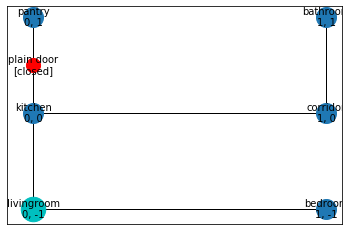

In [32]:
draw_g(graph_w_doors(room_graph_from_kg(gt_kg)), current_pos='livingroom')

In [33]:
def update_kg(gstate, prev_act=None):
    observable_facts, player_room = filter_observables(gstate.facts, verbose=False, game=gstate.game)
    print("FACTS IN SCOPE:")
    for fact in observable_facts:
        prettyprint_fact(fact, game=gstate.game, indent=1)

    viz_kg.update_facts(observable_facts, prev_action=prev_act)
    print(viz_kg.connections)
    return viz_kg, player_room.name

In [34]:
# cmd = "go north"
def step_env(env, cmd, visualize=True):
    gsx,score,done = env.step(cmd)
    print("Score:", score, "GAME OVER!" if done else "")
    print("--------------------------- Feedback: ---------------------------")
    print(gsx.feedback.strip())
    print("\n--------------------------- Description: ---------------------------")
    print(gsx.description)
    print("--------------------------------------------------------------------")
    kg, current_room = update_kg(gsx, prev_act=cmd)
    if visualize:
        draw_g(graph_w_doors(room_graph_from_kg(kg)), current_pos=current_room)
    return kg, current_room

Score: 0 
--------------------------- Feedback: ---------------------------
-= Livingroom =-
Well how about that, you are in a place we're calling a livingroom. Let's see what's in here.

As if things weren't amazing enough already, you can even see a sofa. The sofa is comfy. But there isn't a thing on it.

You don't like doors? Why not try going east, that entranceway is not blocked by one. You don't like doors? Why not try going north, that entranceway is not blocked by one.

--------------------------- Description: ---------------------------
-= Livingroom =-
Well how about that, you are in a place we're calling a livingroom. Let's see what's in here.

As if things weren't amazing enough already, you can even see a sofa. The sofa is comfy. But there isn't a thing on it.

You don't like doors? Why not try going east, that entranceway is not blocked by one. You don't like doors? Why not try going north, that entranceway is not blocked by one.
------------------------------------------

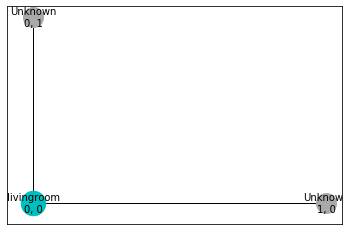

In [35]:
# kg, current_room = update_kg(game_state, prev_act="look")
# draw_g(graph_w_doors(room_graph_from_kg(kg)), current_pos=current_room)
_kg, current_loc = step_env(env, "look")

Score: 0 
--------------------------- Feedback: ---------------------------
-= Kitchen =-
You've entered a kitchen.

You make out a closed fridge. You make out a closed oven in the room. You can make out a table. On the table you see a cookbook. What's that over there? It looks like it's a counter. The counter is vast. On the counter you can make out a knife. You make out a stove. The stove is conventional. However, the stove, like an empty stove, has nothing on it. Hm. Oh well

There is a closed plain door leading north. There is an exit to the east. You need an exit without a door? You should try going south.

--------------------------- Description: ---------------------------
-= Kitchen =-
You've entered a kitchen.

You make out a closed fridge. You make out a closed oven in the room. You can make out a table. On the table you see a cookbook. What's that over there? It looks like it's a counter. The counter is vast. On the counter you can make out a knife. You make out a stove. The

WARNING Location.del_entity could not find entity You


'stove'[stove_0] :---at---: 'kitchen'[r_0]
	'table'[s_0] :---at---: 'kitchen'[r_0]
	'knife'[o_1] :---on---: 'counter'[s_1]
	'cookbook'[o_0] :---on---: 'table'[s_0]
	'water'[f_0] :---in---: 'Inventory'[I]
	'exit_south'[e] :---south_of---: 'kitchen'[r_0]
	'exit_east'[e] :---east_of---: 'kitchen'[r_0]
	'plain door'[d_0] :---north_of---: 'kitchen'[r_0]
	'plain door'[d_0] :---north_of---: 'Player'[P]
*********** observed FACTS *********** 
	DISCOVERED NEW entity: plain door[dirUNK:kitchen *] at kitchen
visit() DISCOVERED kitchen
Action: <go north> CHANGED player location from livingroom to kitchen
	DISCOVERED NEW entity: counter at kitchen
	DISCOVERED NEW entity: fridge at kitchen
	DISCOVERED NEW entity: oven at kitchen
	DISCOVERED NEW entity: stove at kitchen
	DISCOVERED NEW entity: table at kitchen
	ADDED NEW Object knife :on: counter
	ADDED NEW Object cookbook :on: table
---------------- update FACTS end -------------------
Connection Graph:

    outgoing:
:[livingroom] --(north)--> :[ki

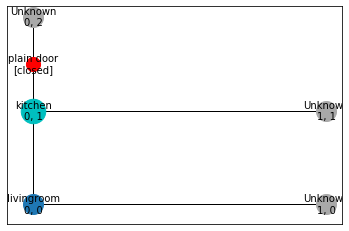

In [36]:
_kg, current_loc = step_env(env, "go north")

Score: 0 
--------------------------- Feedback: ---------------------------
You open plain door.

--------------------------- Description: ---------------------------
-= Kitchen =-
You've entered a kitchen.

You make out a closed fridge. You make out a closed oven in the room. You can make out a table. On the table you see a cookbook. What's that over there? It looks like it's a counter. The counter is vast. On the counter you can make out a knife. You make out a stove. The stove is conventional. However, the stove, like an empty stove, has nothing on it. Hm. Oh well

There is an open plain door leading north. There is an exit to the east. You need an exit without a door? You should try going south.
--------------------------------------------------------------------
at(P, kitchen: r) kitchen: r
FACTS IN SCOPE:
	'plain door'[d_0] :---open
	'Player'[P] :---at---: 'kitchen'[r_0]
	'counter'[s_1] :---at---: 'kitchen'[r_0]
	'fridge'[c_0] :---at---: 'kitchen'[r_0]
	'fridge'[c_0] :---closed
	

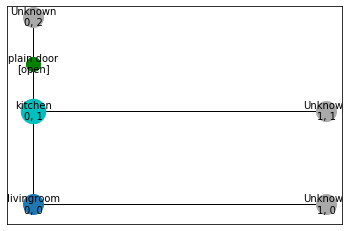

In [37]:
_kg, current_loc = step_env(env, "open plain door")

In [38]:
cmd = "look"

Score: 0 
--------------------------- Feedback: ---------------------------
-= Kitchen =-
You've entered a kitchen.

You make out a closed fridge. You make out a closed oven in the room. You can make out a table. On the table you see a cookbook. What's that over there? It looks like it's a counter. The counter is vast. On the counter you can make out a knife. You make out a stove. The stove is conventional. However, the stove, like an empty stove, has nothing on it. Hm. Oh well

There is an open plain door leading north. There is an exit to the east. You need an exit without a door? You should try going south.

--------------------------- Description: ---------------------------
-= Kitchen =-
You've entered a kitchen.

You make out a closed fridge. You make out a closed oven in the room. You can make out a table. On the table you see a cookbook. What's that over there? It looks like it's a counter. The counter is vast. On the counter you can make out a knife. You make out a stove. The 

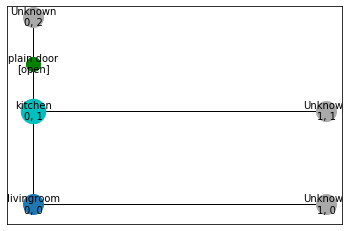

In [39]:
_kg, current_loc = step_env(env, cmd)

In [40]:
# cmd = "go north"
cmd = "go south"
# cmd = "go east"
# cmd = "go west"
# cmd = "open door"
# cmd = "look"
print(cmd)

go south


In [41]:

from IPython.core.display import HTML
HTML('''<script> </script> <form action="javascript:IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()-2, IPython.notebook.get_selected_index()-1)"><input type="submit" id="toggleButton" value="Step( cmd )"></form>''')

WARNING Location.del_entity could not find entity You


Score: 0 
--------------------------- Feedback: ---------------------------
-= Livingroom =-
Well how about that, you are in a place we're calling a livingroom. Let's see what's in here.

As if things weren't amazing enough already, you can even see a sofa. The sofa is comfy. But there isn't a thing on it.

You don't like doors? Why not try going east, that entranceway is not blocked by one. You don't like doors? Why not try going north, that entranceway is not blocked by one.

--------------------------- Description: ---------------------------
-= Livingroom =-
Well how about that, you are in a place we're calling a livingroom. Let's see what's in here.

As if things weren't amazing enough already, you can even see a sofa. The sofa is comfy. But there isn't a thing on it.

You don't like doors? Why not try going east, that entranceway is not blocked by one. You don't like doors? Why not try going north, that entranceway is not blocked by one.
------------------------------------------

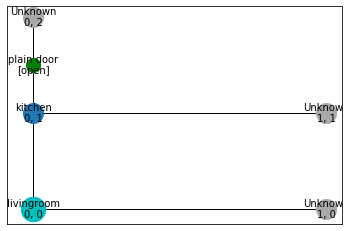

In [42]:
_kg, current_loc = step_env(env, cmd)

In [43]:

game1_name = 'tw-cooking-recipe3+take3+cut+go6-Z7L8CvEPsO53iKDg'
game1 = textworld.generator.Game.load('./tw_games/{}.json'.format(game1_name))

TextWorldUtils.print_game_info(game1)
# textworld.render.visualize(game1)

objective: You are hungry! Let's cook a delicious meal. Check the cookbook in the kitchen for the recipe. Once done, enjoy your meal!

verbs: ['chop', 'close', 'cook', 'dice', 'drink', 'drop', 'eat', 'examine', 'go', 'insert', 'inventory', 'lock', 'look', 'open', 'prepare', 'put', 'slice', 'take', 'unlock']

[('plain door', 'd'), ('fridge', 'c'), ('oven', 'oven'), ('table', 's'), ('counter', 's'), ('shelf', 's'), ('sofa', 's'), ('bed', 's'), ('toilet', 's'), ('stove', 'stove'), ('purple potato', 'f'), ('black pepper', 'f'), ('parsley', 'f'), ('orange bell pepper', 'f'), ('red potato', 'f'), ('meal', 'meal'), ('cookbook', 'o'), ('knife', 'o')]

ROOMS:
r_0: 'kitchen'
r_2: 'livingroom'
r_1: 'pantry'
r_3: 'bedroom'
r_5: 'bathroom'
r_4: 'corridor'
--------------
d_0: 'plain door' [None]
c_0: 'fridge' ['conventional']
oven_0: 'oven' ['conventional']
s_0: 'table' ['massive']
s_1: 'counter' ['vast']
s_2: 'shelf' ['wooden']
s_3: 'sofa' ['comfy']
s_4: 'bed' ['large']
s_5: 'toilet' ['white']
stov

In [44]:
gs,_,_ = env.step("print_state")
# print(gs.description)
print(gs.feedback)

-=STATE START=-
Room: 
 livingroom

World: 
  kitchen
  corridor
  bedroom
  livingroom
  bathroom
  pantry
kitchen:
  plain door (open)
  a fridge (closed)
    a carrot
    a yellow bell pepper
  an oven (closed)
  a table
    a cookbook
  a counter
    a knife
  a stove
corridor:
  nothing
bedroom:
  a bed
livingroom:
  yourself
    some water
  a sofa
bathroom:
  a toilet
pantry:
  a shelf
    a flour
    some olive oil

Inventory:
  some water

Nowhere:
  
  water
  meal (eaten)
  
  
  EndOfObject


Score:
 0/2

Objective:
 You are hungry! Let's cook a delicious meal. Check the cookbook in the kitchen for the recipe. Once done, enjoy your meal!

Inventory description:
  You are carrying: some water.

Room description:

-= Livingroom =-
Well how about that, you are in a place we're calling a livingroom. Let's see what's in here.

As if things weren't amazing enough already, you can even see a sofa. The sofa is comfy. But there isn't a thing on it.

You don't like doors? Why not try

In [45]:
# special commands:
# gs,_,_ = env.step("tw-print player id")
# print("player id:", gs.feedback)
# gs,_,_ = env.step("tw-print EndOfObject id")
# print("EndOfObject id:", gs.feedback)

### OUTPUT:
## player id: 609753
##
## EndOfObject id: 610233

In [46]:
# # print state option: invokes "print_state" on every env step
# gs,_,_ = env.step("enable print state option")
# # print(gs.feedback)
# gs2,_,_ = env.step("go south")
# print(gs2.feedback)
# gs,_,_ = env.step("disable print state option")
# print(gs.feedback)

# Try textworld.gym

In [47]:
request_infos = textworld.EnvInfos(admissible_commands=True, entities=True, facts=True)

In [48]:
import textworld.gym
import gym


In [49]:
# env2.close()

In [50]:
# Requesting additional information should be done when registering the game.
env_id = textworld.gym.register_game('./tw_games/tw-cooking-'+'recipe3-yx19UYoYhLppIrp6.ulx', request_infos)
env2 = gym.make(env_id)


In [51]:
obs,infos = env2.reset()

In [52]:
print(obs)




                    ________  ________  __    __  ________        
                   |        \|        \|  \  |  \|        \       
                    \$$$$$$$$| $$$$$$$$| $$  | $$ \$$$$$$$$       
                      | $$   | $$__     \$$\/  $$   | $$          
                      | $$   | $$  \     >$$  $$    | $$          
                      | $$   | $$$$$    /  $$$$\    | $$          
                      | $$   | $$_____ |  $$ \$$\   | $$          
                      | $$   | $$     \| $$  | $$   | $$          
                       \$$    \$$$$$$$$ \$$   \$$    \$$          
              __       __   ______   _______   __        _______  
             |  \  _  |  \ /      \ |       \ |  \      |       \ 
             | $$ / \ | $$|  $$$$$$\| $$$$$$$\| $$      | $$$$$$$\
             | $$/  $\| $$| $$  | $$| $$__| $$| $$      | $$  | $$
             | $$  $$$\ $$| $$  | $$| $$    $$| $$      | $$  | $$
             | $$ $$\$$\$$| $$  | $$| $$$$$$$\| $$      | $

In [53]:
# show_graph(infos['facts'])


In [54]:
gs2,score,done,infos = env2.step("look")
print(gs2)

-= Kitchen =-
You find yourself in a kitchen. A standard one.

You can see a fridge. The fridge contains a carrot, a block of cheese and a cilantro. As if things weren't amazing enough already, you can even see an oven. You can see a table. The table is massive. On the table you see a cookbook. You make out a counter. The counter is vast. On the counter you can make out a raw purple potato and a red hot pepper. You make out a stove. But the thing is empty.







In [55]:
print(infos.keys())

dict_keys(['entities', 'admissible_commands', 'facts'])
